# Crime Rates in San Diego

This file contains information about crime in the city of San Diego. 
The data used was taken from San Diego Regional Data Library's dataset, San Diego Region Crime Incidents 2007 - 2013. 

Data cleaned by Megan Chang

In [128]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.io as io
import scipy.signal as sig
import math as math
import random 
from scipy import integrate
import matplotlib.pyplot as plt
import h5py

%matplotlib inline
plt.style.use('seaborn-colorblind')
plt.rcParams['image.cmap'] = 'RdBu'

from mpl_toolkits.mplot3d import Axes3D

In [129]:
dfcrime = pd.read_csv('incidents_100k.csv')
dfcode = pd.read_csv('nbrhcodes.csv')
dfzip = pd.read_csv('area_zip_dict.csv')

In [130]:
#examine data
print(dfcrime.head(5))

   id        date  year  month   day  week  dow      time  hour  is_night  \
0 NaN  2008-09-19  2008      9  3184    37    5  13:00:00    13         0   
1 NaN  2008-07-20  2008      7  3123    28    0  22:00:00    22         1   
2 NaN  2009-05-25  2009      5  3432    21    1  00:30:00     0         1   
3 NaN  2011-04-22  2011      4  4129    16    5  19:10:00    19         0   
4 NaN  2012-05-12  2012      5  4515    19    6  21:40:00    21         1   

     ...     comm_pop council coun_pop  asr_zone lampdist        lat  \
0    ...        42779  San005   143957         1     3162  32.957337   
1    ...        15748  San003   147116         3     8000  32.758153   
2    ...        39849  San002   142456         6     2236  32.796761   
3    ...        45697  San003   147116         6     1414  32.757287   
4    ...        77873  San006   140738         1     6082  32.836098   

          lon                                    desc       gctype  gcquality  
0 -117.143777           

In [131]:
print(dfcode.head(5))

           type      city    code  scode                   name         lon  \
0  neighborhood  CaSanSAN  SanADM    103            Adams North -117.119183   
1  neighborhood  CaSanSAN  SanALL     51         Allied Gardens -117.081694   
2  neighborhood  CaSanSAN  SanALT    119             Alta Vista -117.065998   
3  neighborhood  CaSanSAN  SanAZL     12  Azalea/Hollywood Park -117.104734   
4  neighborhood  CaSanSAN  SanBAL     89            Balboa Park -117.145920   

         lat          area  
0  32.768792  2.115885e+07  
1  32.797943  6.459816e+07  
2  32.693359  7.690619e+06  
3  32.732939  9.612716e+06  
4  32.731088  5.686434e+07  


In [132]:
#grab necessary crime data
dfcrime = dfcrime[['year', 'type', 'nbrhood']]
dfcrime.head(5)

,year,type,nbrhood
0,2008,WEAPONS,SanRNC
1,2008,FRAUD,SanNRM
2,2009,ASSAULT,SanPCF
3,2011,DRUGS/ALCOHOL VIOLATIONS,SanNRT
4,2012,ASSAULT,SanNOA


In [133]:
#examine time range of crime records
#dfcrime['year'].value_counts()

In [134]:
#examine types of crime
#dfcrime['type'].value_counts()

In [135]:
#grab neighborhood codes
dfcode = dfcode[['code','name']]

In [136]:
# replace neighborhood codes with names in dfcrime
for i in range(len(dfcode)):
    name = dfcode['name'][i]
    key_code = dfcode['code'][i]
    
    dfcrime.replace(to_replace = key_code, value = name, inplace=True)

In [137]:
# replace spaces with '_' in neighborhood names
dfcrime['nbrhood'] = [str(x.replace(" ","_")) for x in dfcrime['nbrhood'][:]]

In [138]:
dfcrime.head(5)

,year,type,nbrhood
0,2008,WEAPONS,Rancho_Penasquitos
1,2008,FRAUD,Normal_Heights
2,2009,ASSAULT,Pacific_Beach
3,2011,DRUGS/ALCOHOL VIOLATIONS,North_Park
4,2012,ASSAULT,North_Clairemont


In [139]:
dfzip.head(5)

,Area,Zipcode
0,Jamul,91935
1,Wooded_Area,92106
2,Old_Town,92110
3,Spring_Valley,91977 91978
4,Pauma_Valley,92061


In [140]:
# remove neighborhoods in dfcrime for which we don't have the zipcode data for
area = dfzip['Area'].values
dfcrime = dfcrime[dfcrime['nbrhood'].isin(area)]
dfcrime.head(5)

,year,type,nbrhood
0,2008,WEAPONS,Rancho_Penasquitos
1,2008,FRAUD,Normal_Heights
3,2011,DRUGS/ALCOHOL VIOLATIONS,North_Park
4,2012,ASSAULT,North_Clairemont
5,2010,ROBBERY,Clairemont_Mesa_East


In [141]:
# reset index of dfcrime
dfcrime = dfcrime.reset_index()
del dfcrime['index']

In [142]:
dfcrime.head(5)

,year,type,nbrhood
0,2008,WEAPONS,Rancho_Penasquitos
1,2008,FRAUD,Normal_Heights
2,2011,DRUGS/ALCOHOL VIOLATIONS,North_Park
3,2012,ASSAULT,North_Clairemont
4,2010,ROBBERY,Clairemont_Mesa_East


In [143]:
# Sort values and group data by year and neighorhood to get total crimecount
dfcrime = dfcrime.sort_values(['year', 'nbrhood'], ascending=[True, True])
dfgroup = dfcrime.groupby(["year", "nbrhood"]).size()

# Take series and convert to dataframe. Reset index and rename columns
dfsort = dfgroup.to_frame()
dfsort = dfsort.reset_index()
dfsort.columns = ['year', 'nbrhood', 'crimecount']


In [144]:
zips = []
for i in range(len(dfsort['nbrhood'])):
    name = dfsort['nbrhood'][i]
    for j in range(len(dfzip['Zipcode'])):
        area = dfzip['Area'][j]
        zipcode = dfzip['Zipcode'][j]
        if name == area:
            zips.append(zipcode)


In [145]:
dfsort['zipcode'] = pd.Series(zips, index = dfsort.index)

In [146]:
del dfsort['nbrhood']

In [147]:
# sort by zipcode
dfsort = dfsort.sort_values(['zipcode', 'year'],ascending = [True, True])


In [148]:
dfsort = dfsort.reset_index()
del dfsort['index']

In [149]:
dfsort['zipcode'] = [int(x.replace(" ","")) for x in dfsort['zipcode'][:]]

In [150]:
#zipcode with highest crime count
print(dfsort.iloc[dfsort['crimecount'].idxmax])


year           2008
crimecount      741
zipcode       92104
Name: 25, dtype: int64


In [151]:
#cv_count = dfsort[dfsort['zipcode'] == 92130] 
#lj_count = dfsort[dfsort['zipcode'] == 92037]
#barriologan_count = dfsort[dfsort['zipcode'] == 92113]
#northpark_count = dfsort[dfsort['zipcode'] == 92104]

#cv_crime = cv_count['crimecount']
#lj_crime = lj_count['crimecount']
#barriologan_crime = barriologan_count['crimecount']
#northpark_crime = northpark_count['crimecount']

#plt.plot(lj_count['year'], lj_count['crimecount'])

#avg_crime_cv = cv_crime.mean
#avg_crime_lj = lj_crime.mean
#avg_crime_bl = barriologan_crime.mean
#avg_crime_np = northpark_crime.mean



In [152]:
year_range = dfsort['year'].value_counts()
years = len(year_range)
year_list = list(year_range.keys())
year_list = sorted(year_list, key=int)   

zip_range = dfsort['zipcode'].value_counts()
zip_num = len(zip_range)
zip_list = list(zip_range.keys())
zip_list = sorted(zip_list, key = int)
year_list

[2007, 2008, 2009, 2010, 2011, 2012]

In [153]:
dfsort['crimecount'].head(5)

0    512
1    450
2    429
3    346
4    385
Name: crimecount, dtype: int64

In [160]:
crimebread = np.zeros((years, zip_num))
for i in range(years):   
    for zips in zip_list:     
        #extracts all crime counts with corresponding year in dfsort data and inserts into array of crimebread 
        crimebread[i][:] = dfsort['crimecount'][dfsort['year'] == year_list[i]]

crimebread3D = np.zeros((years, 2, zip_num), dtype=np.int)
for i in range(years):   
    for zips in zip_list:
        #extracts all crime counts with corresponding year in dfsort data and inserts into array of crimebread
        crimebread3D[i][0][:] = dfsort['crimecount'][dfsort['year'] == year_list[i]]
    for j in range(len(zip_list)):
        crimebread3D[i][1][j] = int(zip_list[j])
        

crimebread3D

array([[[  512,   233,   198,   305,   719,   151,    23,   616,   463,
           321,    83,   312,   217,   156,   157,   211,   167,   108,
            73,   135,   391,   217,   140,   448,    24,    99,   253,
           290,   107,   127,   541],
        [92037, 92101, 92102, 92103, 92104, 92105, 92106, 92107, 92108,
         92109, 92110, 92111, 92113, 92114, 92115, 92116, 92117, 92119,
         92120, 92121, 92122, 92123, 92124, 92126, 92127, 92128, 92129,
         92130, 92139, 92154, 92173]],

       [[  450,   219,   179,   387,   741,   164,    33,   500,   457,
           278,    75,   318,   198,   137,   116,   234,   170,   119,
            69,    88,   387,   272,   153,   495,    13,    98,   253,
           263,   117,   126,   510],
        [92037, 92101, 92102, 92103, 92104, 92105, 92106, 92107, 92108,
         92109, 92110, 92111, 92113, 92114, 92115, 92116, 92117, 92119,
         92120, 92121, 92122, 92123, 92124, 92126, 92127, 92128, 92129,
         92130, 9213

In [158]:
#plt.plot(crimebread3D.T[0][0][:], crimebread3D[0][1][:])
numcr = []
for i in range(len(year_list)):
    numcr.append(list(crimebread3D[i][0][:]))

x = list(crimebread3D[0][1][:])

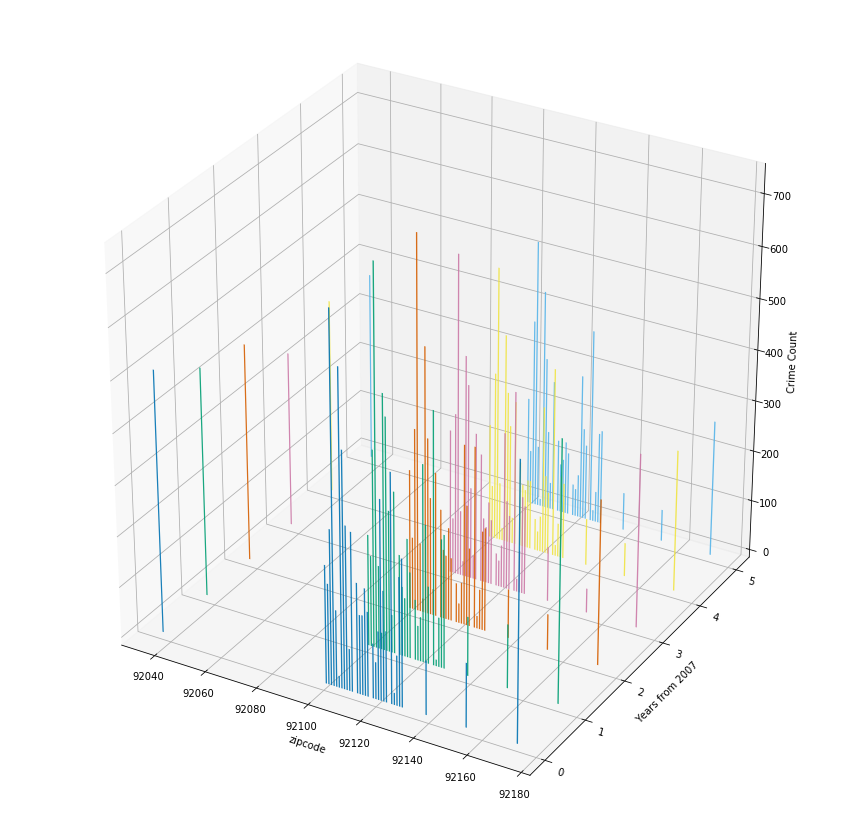

In [159]:
fig = plt.figure(1, figsize=(15,15))

ax = fig.add_subplot(111, projection='3d')
#['r', 'g', 'b', 'y', 'r', 'g']
idk = [0, 1, 2, 3 , 4, 5]

for c, f in zip(['r', 'g', 'b', 'y', 'r', 'g'], [0, 1, 2, 3, 4, 5]):
    xs = x #zipcode
    z = numcr[f]
    ax.bar(xs, z, f, zdir = 'y', alpha = .9, width = .5)

ax.set_xlabel('zipcode') 
ax.set_ylabel('Years from 2007') 
ax.set_zlabel('Crime Count') 
#ax.set_yticks([2007, 2008, 2009, 2010, 2011, 2012])
#ax.set_yticklabels()
labels = {}
for l_c in range(0,6):
    labels[l_c] = 'This is not normal'

ax.set_yticklabels(labels, rotation = -15, verticalalignment = 'baseline', horizontalalignment = 'left')
plt.show()



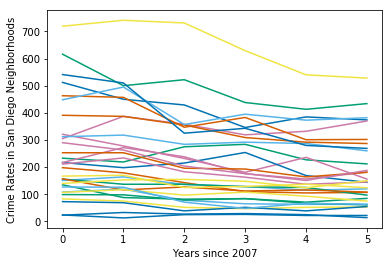

In [104]:
# graph crime rates throughout years 2007 - 2012 for all San Diego City Neighborhoods
plt.xlabel('Years since 2007')
plt.ylabel('Crime Rates in San Diego Neighborhoods')

_ = plt.plot(crimebread[:][:])

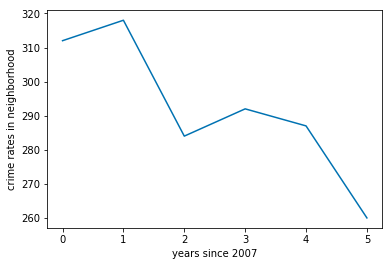

In [105]:
# accessing by each zipcode
plt.xlabel('years since 2007')
plt.ylabel('crime rates in neighborhood')
# color: each zipcode
_ = plt.plot(crimebread.T[:][11]) #La Jolla

In [106]:
#sum total number of crimes in San Diego city for each year
year_range = [2007, 2008, 2009, 2010, 2011, 2012]
total_2007 = np.sum(crimebread[:][0])
total_2008 = np.sum(crimebread[:][1])
total_2009 = np.sum(crimebread[:][2])
total_2010 = np.sum(crimebread[:][3])
total_2011 = np.sum(crimebread[:][4])
total_2012 = np.sum(crimebread[:][5])

totalcrime = [total_2007, total_2008, total_2009, total_2010, total_2011, total_2012]
#plt.plot(year_range, totalcrime)
print(totalcrime)

[7797.0, 7619.0, 6624.0, 6180.0, 5664.0, 5611.0]


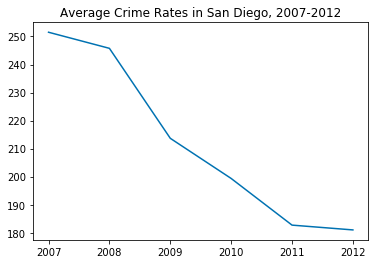

In [107]:
#find average crime rate in San Diego city for each year
crime_2007 = crimebread[:][0]
avgcrime_2007 = np.average(crime_2007)
crime_2008 = crimebread[:][1]
avgcrime_2008 = np.average(crime_2008)
crime_2009 = crimebread[:][2]
avgcrime_2009 = np.average(crime_2009)
crime_2010 = crimebread[:][3]
avgcrime_2010 = np.average(crime_2010)
crime_2011 = crimebread[:][4]
avgcrime_2011 = np.average(crime_2011)
crime_2012 = crimebread[:][5]
avgcrime_2012 = np.average(crime_2012)

#plot average crime rate in San Diego city for each year
avgcrime = [avgcrime_2007, avgcrime_2008, avgcrime_2009, avgcrime_2010, avgcrime_2011, avgcrime_2012]
avgcrime_graph = plt.plot(year_range, avgcrime)
plt.title('Average Crime Rates in San Diego, 2007-2012')

<Container object of 31 artists>

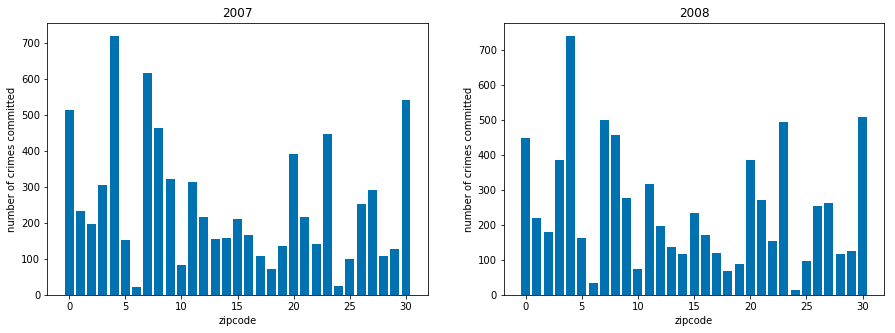

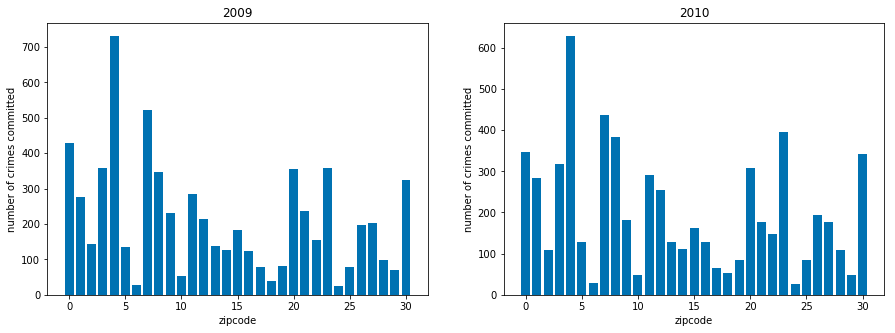

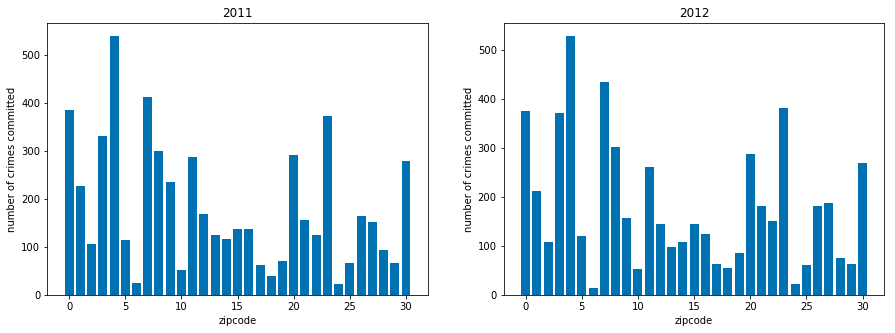

In [108]:
zipcrime_2007 = []
zipcrime_2008 = []
zipcrime_2009 = []
zipcrime_2010 = []
zipcrime_2011 = []
zipcrime_2012 = []

for j in range(len(crimebread)):
    for i in range(len(crimebread[j])):
        if j == 0:
            zipcrime_2007.append(crimebread[j][i])
        if j == 1:
            zipcrime_2008.append(crimebread[j][i])
        if j == 2:
            zipcrime_2009.append(crimebread[j][i])
        if j == 3:
            zipcrime_2010.append(crimebread[j][i])
        if j == 4:
            zipcrime_2011.append(crimebread[j][i])
        if j == 5:
            zipcrime_2012.append(crimebread[j][i])

plt.figure(1,figsize=(15,5))
plt.subplot(1,2,1)
plt.title(year_list[0])
plt.xlabel('zipcode')
plt.ylabel('number of crimes committed')
plt.bar(list(range(len(zip_list))), zipcrime_2007)
plt.subplot(1,2,2)
plt.title(year_list[1])
plt.xlabel('zipcode')
plt.ylabel('number of crimes committed')
plt.bar(list(range(len(zip_list))), zipcrime_2008)


plt.figure(2,figsize=(15,5))
plt.subplot(1,2,1)
plt.title(year_list[2])
plt.xlabel('zipcode')
plt.ylabel('number of crimes committed')
plt.bar(list(range(len(zip_list))), zipcrime_2009)
plt.subplot(1,2,2)
plt.title(year_list[3])
plt.xlabel('zipcode')
plt.ylabel('number of crimes committed')
plt.bar(list(range(len(zip_list))), zipcrime_2010)


plt.figure(3,figsize=(15,5))
plt.subplot(1,2,1)
plt.title(year_list[4])
plt.xlabel('zipcode')
plt.ylabel('number of crimes committed')
plt.bar(list(range(len(zip_list))), zipcrime_2011)
plt.subplot(1,2,2)
plt.title(year_list[5])
plt.xlabel('zipcode')
plt.ylabel('number of crimes committed')
plt.bar(list(range(len(zip_list))), zipcrime_2012)

The number of crime counts above average in 2007 is 72
The number of crime counts below average in 2007 is 114
The number of crime counts above average in 2008 is 78
The number of crime counts below average in 2008 is 108
The number of crime counts above average in 2009 is 78
The number of crime counts below average in 2009 is 108
The number of crime counts above average in 2010 is 66
The number of crime counts below average in 2010 is 120
The number of crime counts above average in 2011 is 66
The number of crime counts below average in 2011 is 120
The number of crime counts above average in 2012 is 72
The number of crime counts below average in 2012 is 114


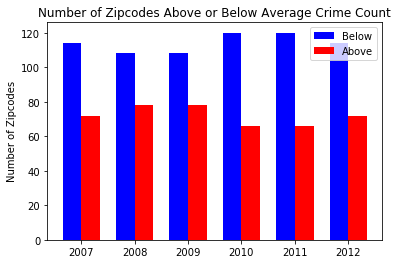

In [109]:
above_count0 = 0
below_count0 = 0
above_count1 = 0
below_count1 = 0
above_count2 = 0
below_count2 = 0
above_count3 = 0
below_count3 = 0
above_count4 = 0
below_count4 = 0
above_count5 = 0
below_count5 = 0

for i in range(len(totalcrime)):
    for j in range(len(zipcrime_2007)):
        if zipcrime_2007[j] > avgcrime_2007:
            above_count0+=1
        if zipcrime_2007[j] <= avgcrime_2007:
            below_count0+=1
    for j in range(len(zipcrime_2008)):
        if zipcrime_2008[j] > avgcrime_2008:
            above_count1+=1
        if zipcrime_2008[j] <= avgcrime_2008:
            below_count1+=1
    for j in range(len(zipcrime_2009)):
        if zipcrime_2009[j] > avgcrime_2009:
            above_count2+=1
        if zipcrime_2009[j] <= avgcrime_2009:
            below_count2+=1      
    for j in range(len(zipcrime_2010)):
        if zipcrime_2010[j] > avgcrime_2010:
            above_count3+=1
        if zipcrime_2010[j] <= avgcrime_2010:
            below_count3+=1      
    for j in range(len(zipcrime_2011)):
        if zipcrime_2011[j] > avgcrime_2011:
            above_count4+=1
        if zipcrime_2011[j] <= avgcrime_2011:
            below_count4+=1      
    for j in range(len(zipcrime_2012)):
        if zipcrime_2012[j] > avgcrime_2012:
            above_count5+=1
        if zipcrime_2012[j] <= avgcrime_2012:
            below_count5+=1  
            
print('The number of crime counts above average in 2007 is ' + str(above_count0))
print('The number of crime counts below average in 2007 is ' + str(below_count0))
print('The number of crime counts above average in 2008 is ' + str(above_count1))
print('The number of crime counts below average in 2008 is ' + str(below_count1))
print('The number of crime counts above average in 2009 is ' + str(above_count2))
print('The number of crime counts below average in 2009 is ' + str(below_count2))
print('The number of crime counts above average in 2010 is ' + str(above_count3))
print('The number of crime counts below average in 2010 is ' + str(below_count3))
print('The number of crime counts above average in 2011 is ' + str(above_count4))
print('The number of crime counts below average in 2011 is ' + str(below_count4))
print('The number of crime counts above average in 2012 is ' + str(above_count5))
print('The number of crime counts below average in 2012 is ' + str(below_count5))
    
    
above = [above_count0, above_count1, above_count2, above_count3, above_count4, above_count5]
below = [below_count0, below_count1, below_count2, below_count3, below_count4, below_count5]

ind = np.arange(len(totalcrime))  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, below, width, color='b')

rects2 = ax.bar(ind + width, above, width, color='r')

# add some text for labels, title and axes ticks
ax.set_ylabel('Number of Zipcodes')
ax.set_title('Number of Zipcodes Above or Below Average Crime Count')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('2007', '2008', '2009', '2010', '2011', '2012'))

ax.legend((rects1[0], rects2[0]), ('Below', 'Above'))


plt.show()
    

# creating data in h5py loaf
cogs108h5 = h5py.File('cogs108.h5', 'a')
cogs108h5.create_dataset('crime_rate', data = crimebread )
cogs108h5.close()


In [119]:
bread = []
#load data from h5 
h5_file = '../COGS108-Gentrification/cogs108.h5'
#reading data
with h5py.File(h5_file, 'r') as h5:
    #print([x for x in h5.keys()])
    dset = h5['crime_rate_5y']
    bread = dset[:][:]